In [29]:
import numpy as np
import matplotlib.pyplot as plt
import time

# generate data

生成数据得函数由助教的代码更改而来，其中增加了一个 `seed` 参数，为了是能获取一样的数据，以方便不同模型以及参数之间的训练结果比较。 

In [30]:
# In real world, you cannot learn how the data was generated. So do not rely on this function when coding your lab.
def generate_data(dim, num, seed):
    np.random.seed(seed)
    x = np.random.normal(0, 10, [num, dim])
    coef = np.random.uniform(-1, 1, [dim, 1])
    pred = np.dot(x, coef)
    pred_n = (pred - np.mean(pred)) / np.sqrt(np.var(pred))
    label = np.sign(pred_n)
    mislabel_value = np.random.uniform(0, 1, num)
    mislabel = 0
    for i in range(num):
        if np.abs(pred_n[i]) < 1 and mislabel_value[i] > 0.9 + 0.1 * np.abs(pred_n[i]):
            label[i] *= -1
            mislabel += 1
    return x, label, mislabel/num

# write your model class

`SVM1` 的目标优化函数是 `hinge` 损失函数加上正则化项。即优化的目标函数是

$$
\min\limits_{\pmb{w},b}=\frac{1}{2}C_1\vert\vert\pmb{w}\vert\vert^2+C_2\sum_{i=1}^n\max(0,1-y_i(\pmb{w}^T\pmb{x}_i+b))
$$

在这里，为了方便训练，我们像逻辑斯蒂回归那样，令 

$$
\pmb{\hat{w}}=(\pmb{w};b)\quad\pmb{\hat{x}}=(\pmb{x};1)
$$

所以只需要对 $\pmb{\hat{w}}$ 进行优化求解即可

In [31]:
# you can do anything necessary about the model
class SVM1:
    def __init__(self, dim, num):
        """
        You can add some other parameters, which I think is not necessary
        """
        self.dim = dim + 1
        self.num = num
        self.weights = np.ones((self.dim, 1))  # dim x 1
        self.train_loss = []

    def fit(self, X, y, C1=1e-2, C2=1e-5, lr=0.01, tol=1e-3, max_iter=1e5):
        """
        Fit the coefficients via your methods
        """
        early_stop = False
        for iteration in range(int(max_iter)):
            # print(iteration)
            # X: num x dim    self.weights: dim x 1

            z = y * np.dot(X, self.weights)     # num x 1
            hinge = np.maximum(0, 1 - z)        # num x 1

            hinge_grad = -y * X * C2                  # num x dim
            hinge_grad[np.where(hinge == 0)[0]] = 0         # num x dim
            hinge_grad = np.sum(hinge_grad, axis=0)         # dim x 1

            grad = hinge_grad.reshape((-1, 1)) + C1 * self.weights

            hinge_loss = np.sum(hinge) * C2      # 1 x 1
            loss = C1 * 0.5 * np.linalg.norm(self.weights) + hinge_loss
            self.train_loss.append(loss)

            if (np.absolute(grad) < tol).all():
                early_stop = True
                print("early stop at iteration {}.".format(iteration))
                break
            self.weights = self.weights - lr * grad
        if not early_stop:
            print("stop at iteration {}.".format(int(max_iter)))

    def predict(self, X):
        """
        Use the trained model to generate prediction probabilities on a new
        collection of data points.
        """
        product = np.dot(X, self.weights)
        pred = np.ones((len(product), 1))
        pred[np.where(product <= -1)] = -1
        return pred

In [32]:
# you can do anything necessary about the model
class SVM2:
    def __init__(self, dim, num):
        """
        You can add some other parameters, which I think is not necessary
        """
        self.dim = dim
        self.num = num
        self.alpha = np.ones((self.num, 1))
        self.C = 1.0
        self.b = 0
        self.alpha_y_k = np.zeros(self.dim)

    def fit(self, X, y, max_iter=1e5):
        """
        Fit the coefficients via your methods
        """
        self.X = X
        self.y = y
        self.weight()

        for iteration in range(int(max_iter)):
            i, j = self.selectAlpha()
            if i == -1 and j == -1:
                print("early stop at iteration {}".format(iteration))
                break
            E_i = self.e(i)
            E_j = self.e(j)
            X_i = self.X[i]
            X_j = self.X[j]
            alpha_i_old, alpha_j_old = self.alpha[i], self.alpha[j]

            L, H = self.LH(i, j)
            eta = self.kernel(X_i, X_i) + self.kernel(X_j, X_j) - 2 * self.kernel(X_i, X_j)
            if eta <= 0:
                continue
            
            alpha_j = alpha_j_old + self.y[j] * (E_i - E_j) / eta
            
            if alpha_j > H:
                alpha_j = H
            elif alpha_j < L:
                alpha_j = L
            
            alpha_i = alpha_i_old + self.y[i] * self.y[j] * (alpha_j_old - alpha_j)
            
            b_1 = self.b - E_i - self.y[i] * (alpha_i - alpha_i_old) * self.kernel(X_i, X_i) - self.y[j] * (alpha_j - alpha_j_old) * self.kernel(X_j, X_i)
            b_2 = self.b - E_j - self.y[i] * (alpha_i - alpha_i_old) * self.kernel(X_i, X_j) - self.y[j] * (alpha_j - alpha_j_old) * self.kernel(X_j, X_j)
            if 0 < alpha_i < self.C:
                self.b = b_1
            elif 0 < alpha_j < self.C:
                self.b = b_2
            else:
                self.b = (b_1 + b_2) / 2

            self.alpha[i] = alpha_i
            self.alpha[j] = alpha_j
            self.weight()
        return
            
    def predict(self, X):
        """
        Use the trained model to generate prediction probabilities on a new
        collection of data points.
        """
        pred = X @ self.alpha_y_k
        pred[pred > 0] = 1
        pred[pred <= 0] = -1
        return pred

    def selectAlpha(self):
        alpha_index = [i for i in range(self.num) if 0 < self.alpha[i] < self.C]
        index = [i for i in range(self.num) if i not in alpha_index]
        alpha_index.extend(index)

        for i in alpha_index:
            if self.kkt(i):
                continue
            j = np.random.randint(self.num)
            while i == j:
                print("re-select")
                j = np.random.randint(self.num)
            return i, j
        return -1, -1

    def kkt(self, i):
        product = self.y[i] * self.g(i)
        if self.alpha[i] == 0:
            return product >= 1
        elif 0 < self.alpha[i] < self.C:
            return product == 1
        else:
            return product <= 1

    def LH(self, i, j):
        if self.y[i] != self.y[j]:
            L = max(0, self.alpha[j] - self.alpha[i])
            H = min(self.C, self.C + self.alpha[j] - self.alpha[i])
        else:
            L = max(0, self.alpha[i] + self.alpha[j] - self.C)
            H = min(self.C, self.alpha[i] + self.alpha[j])
        return L, H

    def e(self, i):
        return self.g(i) - self.y[i]

    def g(self, i):
        val = self.X[i] @ self.alpha_y_k
        return val

    def kernel(self, x1, x2):
        return np.dot(x1, x2)

    def weight(self):
        val = self.b
        for i in range(self.num):
            val = val + self.alpha[i] * self.y[i] * self.X[i].T
        self.alpha_y_k = val
        return 

`SVM2` 的方法采用的是简化后的 `SMO` 算法，目的是为了提高 `SMO` 算法的速度，因为对于很大数据集来说，`SMO` 的计算消耗时间会快速增长，所以采用简化后的 `SMO` 算法，可以提高速度。


In [33]:
# you can do anything necessary about the model
class SVM3:
    def __init__(self, dim, num):
        """
        You can add some other parameters, which I think is not necessary
        """
        self.dim = dim
        self.num = num
        self.alpha = np.ones((self.num, 1))
        self.C = 1.0
        self.alpha_y_k = np.zeros(self.dim)

    def fit(self, X, y, max_iter=1e5):
        """
        Fit the coefficients via your methods
        """
        self.X = X
        self.y = y
        self.weight()

        for iteration in range(int(max_iter)):
            i, j = self.selectAlpha()
            if i == -1 and j == -1:
                print("early stop at iteration {}".format(iteration))
                break
            E_i = self.e(i)
            E_j = self.e(j)
            X_i = self.X[i]
            X_j = self.X[j]
            alpha_i_old, alpha_j_old = self.alpha[i], self.alpha[j]

            L, H = self.LH(i, j)
            eta = self.kernel(X_i, X_i) + self.kernel(X_j, X_j) - 2 * self.kernel(X_i, X_j)
            if eta <= 0:
                continue
            
            alpha_j = alpha_j_old + self.y[j] * (E_i - E_j) / eta
            
            if alpha_j > H:
                alpha_j = H
            elif alpha_j < L:
                alpha_j = L
            
            alpha_i = alpha_i_old + self.y[i] * self.y[j] * (alpha_j_old - alpha_j)
            
            self.alpha[i] = alpha_i
            self.alpha[j] = alpha_j
            self.weight()
        return
            
    def predict(self, X):
        """
        Use the trained model to generate prediction probabilities on a new
        collection of data points.
        """
        pred = X @ self.alpha_y_k
        pred[pred > 0] = 1
        pred[pred <= 0] = -1
        return pred

    def selectAlpha(self):
        alpha_index = [i for i in range(self.num) if 0 < self.alpha[i] < self.C]
        index = [i for i in range(self.num) if i not in alpha_index]
        alpha_index.extend(index)

        for i in alpha_index:
            if self.kkt(i):
                continue
            j = np.random.randint(self.num)
            while i == j:
                print("re-select")
                j = np.random.randint(self.num)
            return i, j
        return -1, -1

    def kkt(self, i):
        product = self.y[i] * self.g(i)
        if self.alpha[i] == 0:
            return product >= 1
        elif 0 < self.alpha[i] < self.C:
            return product == 1
        else:
            return product <= 1

    def LH(self, i, j):
        if self.y[i] != self.y[j]:
            L = max(0, self.alpha[j] - self.alpha[i])
            H = min(self.C, self.C + self.alpha[j] - self.alpha[i])
        else:
            L = max(0, self.alpha[i] + self.alpha[j] - self.C)
            H = min(self.C, self.alpha[i] + self.alpha[j])
        return L, H

    def e(self, i):
        return self.g(i) - self.y[i]

    def g(self, i):
        val = self.X[i] @ self.alpha_y_k
        return val

    def kernel(self, x1, x2):
        return np.dot(x1, x2)

    def weight(self):
        for i in range(self.num):
            self.alpha_y_k = self.alpha_y_k + self.alpha[i] * self.y[i] * self.X[i].T
        return 

# construct and train your models

在训练数据集的最后一列增加一维 $(1,1,...,1)^T$

In [34]:
def biasInsert(X, dim, num):
    bias = np.ones(num)
    return np.insert(X, dim, bias, axis=1)

划分数据集采用的方式是从留出法，由于数据集本身就是随机生成的，因此我认为做1次留出法即可代表该数据集的平均训练效果

In [35]:
def datasetSplit(X, y, num, frac=0.8):
    X_train, y_train = X[:int(frac*num)], y[:int(frac*num)]
    X_test, y_test = X[int(frac*num)+1:num], y[int(frac*num)+1:num]
    return X_train, y_train, X_test, y_test

`SVM1` 在不同数据集下以及不同参数下的训练

early stop at iteration 3537.
model1's running time is 7.0789642333984375s
early stop at iteration 1205.
model1_C1's running time is 2.235086441040039s
stop at iteration 10000.
model1_C2's running time is 18.75529408454895s
stop at iteration 10000.
model1_lr's running time is 18.58982539176941s


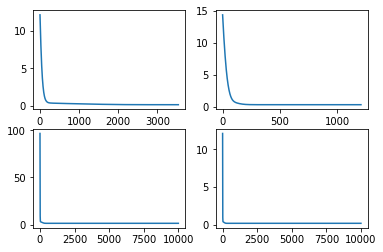

In [47]:
# generate data
dim1, num1, seed1 = 20, 10000, 3407
X_data, y_data, mislabel = generate_data(dim1, num1, seed1)
X = biasInsert(X_data, dim1, num1)

# split data
X_train1, y_train1, X_test1, y_test1 = datasetSplit(X, y_data, num1)
 
# constrcut model and train (remember record time)
model1 = SVM1(dim1, len(y_train1))
start_time = time.time()
model1.fit(X_train1, y_train1, C1=0.01, C2=1/len(y_train1), lr=0.01, tol=5e-3, max_iter=1e4)
end_time = time.time()
print("model1's running time is {}s".format(end_time - start_time, '.3f'))

model1_C1 = SVM1(dim1, len(y_train1))
start_time = time.time()
model1_C1.fit(X_train1, y_train1, C1=1, C2=1/len(y_train1), lr=0.01, tol=5e-3, max_iter=1e4)
end_time = time.time()
print("model1_C1's running time is {}s".format(end_time - start_time, '.3f'))

model1_C2 = SVM1(dim1, len(y_train1))
start_time = time.time()
model1_C2.fit(X_train1, y_train1, C1=0.01, C2=1e-3, lr=0.01, tol=5e-3, max_iter=1e4)
end_time = time.time()
print("model1_C2's running time is {}s".format(end_time - start_time, '.3f'))

model1_lr = SVM1(dim1, len(y_train1))
start_time = time.time()
model1_lr.fit(X_train1, y_train1, C1=0.01, C2=1/len(y_train1), lr=0.1, tol=5e-3, max_iter=1e4)
end_time = time.time()
print("model1_lr's running time is {}s".format(end_time - start_time, '.3f'))

plt.subplot(2, 2, 1)
plt.plot(model1.train_loss)
plt.subplot(2, 2, 2)
plt.plot(model1_C1.train_loss)
plt.subplot(2, 2, 3)
plt.plot(model1_C2.train_loss)
plt.subplot(2, 2, 4)
plt.plot(model1_lr.train_loss)

`SVM1` 在不同数据集上训练

early stop at iteration 3095.
model1_2's running time is 6.059170246124268s
early stop at iteration 3115.
model1_3's running time is 6.010552406311035s
early stop at iteration 3707.
model1_4's running time is 6.921064615249634s


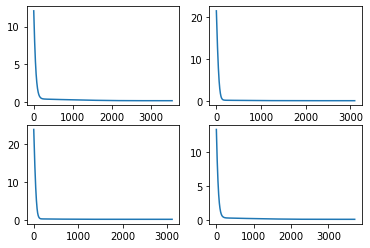

In [37]:
dim2, num2, seed2 = 20, 10000, 1234
X_data, y_data, mislabel = generate_data(dim2, num2, seed2)
X = biasInsert(X_data, dim2, num2)
X_train2, y_train2, X_test2, y_test2 = datasetSplit(X, y_data, num2)

model1_2 = SVM1(dim2, len(y_train2))
start_time = time.time()
model1_2.fit(X_train2, y_train2, C1=0.01, C2=1/len(y_train2), lr=0.01, tol=5e-3, max_iter=1e4)
end_time = time.time()
print("model1_2's running time is {}s".format(end_time - start_time, '.3f'))


dim3, num3, seed3 = 20, 10000, 6666
X_data, y_data, mislabel = generate_data(dim2, num2, seed3)
X = biasInsert(X_data, dim3, num3)
X_train3, y_train3, X_test3, y_test3 = datasetSplit(X, y_data, num3)

model1_3 = SVM1(dim3, len(y_train3))
start_time = time.time()
model1_3.fit(X_train3, y_train3, C1=0.01, C2=1/len(y_train3), lr=0.01, tol=5e-3, max_iter=1e4)
end_time = time.time()
print("model1_3's running time is {}s".format(end_time - start_time, '.3f'))


dim4, num4, seed4 = 20, 10000, 2333
X_data, y_data, mislabel = generate_data(dim2, num2, seed4)
X = biasInsert(X_data, dim3, num3)
X_train4, y_train4, X_test4, y_test4 = datasetSplit(X, y_data, num3)

model1_4 = SVM1(dim4, len(y_train4))
start_time = time.time()
model1_4.fit(X_train4, y_train4, C1=0.01, C2=1/len(y_train4), lr=0.01, tol=5e-3, max_iter=1e4)
end_time = time.time()
print("model1_4's running time is {}s".format(end_time - start_time, '.3f'))

plt.subplot(2, 2, 1)
plt.plot(model1.train_loss)
plt.subplot(2, 2, 2)
plt.plot(model1_2.train_loss)
plt.subplot(2, 2, 3)
plt.plot(model1_3.train_loss)
plt.subplot(2, 2, 4)
plt.plot(model1_4.train_loss)

`SVM2` 在不同数据集下训练

In [38]:
dim1, num1, seed1 = 20, 10000, 3407
X_data, y_data, mislabel = generate_data(dim1, num1, seed1)
X_train_smo1, y_train_smo1, X_test_smo1, y_test_smo1 = datasetSplit(X_data, y_data, num1)

model2_1 = SVM2(dim1, len(y_train_smo1))
start_time = time.time()
model2_1.fit(X_train_smo1, y_train_smo1, max_iter=200)
end_time = time.time()
print("smo model2_1's running time is {}s".format(end_time - start_time, '.3f'))


dim2, num2, seed2 = 20, 10000, 1234
X_data, y_data, mislabel = generate_data(dim2, num2, seed2)
X_train_smo2, y_train_smo2, X_test_smo2, y_test_smo2 = datasetSplit(X_data, y_data, num2)

model2_2 = SVM2(dim2, len(y_train_smo2))
start_time = time.time()
model2_2.fit(X_train_smo2, y_train_smo2, max_iter=200)
end_time = time.time()
print("smo model2_2's running time is {}s".format(end_time - start_time, '.3f'))


dim3, num3, seed3 = 20, 10000, 6666
X_data, y_data, mislabel = generate_data(dim3, num3, seed3)
X_train_smo3, y_train_smo3, X_test_smo3, y_test_smo3 = datasetSplit(X_data, y_data, num3)

model2_3 = SVM2(dim3, len(y_train_smo3))
start_time = time.time()
model2_3.fit(X_train_smo3, y_train_smo3, max_iter=200)
end_time = time.time()
print("smo model2_3's running time is {}s".format(end_time - start_time, '.3f'))


dim4, num4, seed4 = 20, 10000, 2333
X_data, y_data, mislabel = generate_data(dim4, num4, seed4)
X_train_smo4, y_train_smo4, X_test_smo4, y_test_smo4 = datasetSplit(X_data, y_data, num4)

model2_4 = SVM2(dim4, len(y_train_smo4))
start_time = time.time()
model2_4.fit(X_train_smo4, y_train_smo4, max_iter=200)
end_time = time.time()
print("smo model2_4's running time is {}s".format(end_time - start_time, '.3f'))

smo model2_1's running time is 9.13943862915039s
smo model2_2's running time is 9.186999797821045s
smo model2_3's running time is 9.16027283668518s
smo model2_4's running time is 9.214763164520264s


`SVM3` 在不同数据集下的训练

In [39]:
model3_1 = SVM3(dim1, len(y_train_smo1))
start_time = time.time()
model3_1.fit(X_train_smo1, y_train_smo1, max_iter=200)
end_time = time.time()
print("smo model3_1's running time is {}s".format(end_time - start_time, '.3f'))

model3_2 = SVM3(dim2, len(y_train_smo2))
start_time = time.time()
model3_2.fit(X_train_smo2, y_train_smo2, max_iter=200)
end_time = time.time()
print("smo model3_2's running time is {}s".format(end_time - start_time, '.3f'))

model3_3 = SVM3(dim3, len(y_train_smo3))
start_time = time.time()
model3_3.fit(X_train_smo3, y_train_smo3, max_iter=200)
end_time = time.time()
print("smo model3_3's running time is {}s".format(end_time - start_time, '.3f'))

model3_4 = SVM3(dim4, len(y_train_smo4))
start_time = time.time()
model3_4.fit(X_train_smo4, y_train_smo4, max_iter=200)
end_time = time.time()
print("smo model3_4's running time is {}s".format(end_time - start_time, '.3f'))

smo model3_1's running time is 9.388388872146606s
smo model3_2's running time is 9.31456708908081s
smo model3_3's running time is 9.2916100025177s
smo model3_4's running time is 10.638401746749878s


下面是 `sklearn` 中的 SVM 模型

In [40]:
import sklearn.svm as svm
sklearn_model1 = svm.SVC(kernel='linear')
sklearn_model1.fit(X_train_smo1, y_train_smo1)

sklearn_model2 = svm.SVC(kernel='linear')
sklearn_model2.fit(X_train_smo2, y_train_smo2)

sklearn_model3 = svm.SVC(kernel='linear')
sklearn_model3.fit(X_train_smo3, y_train_smo3)

sklearn_model4 = svm.SVC(kernel='linear')
sklearn_model4.fit(X_train_smo4, y_train_smo4)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

SVC(kernel='linear')

# predict and compare your results

预测准确率的函数

In [41]:
def accuracyCalculate(y_pred, y):
    count = np.argwhere(y_pred.reshape(-1, 1) == y)
    return len(count) / len(y)

`SVM1` 模型的准确率

In [48]:
pred1 = model1.predict(X_test1)
accuracy = accuracyCalculate(pred1, y_test1)
print("model1's accuray is {}".format(accuracy))
pred1_C1 = model1_C1.predict(X_test1)
accuracy = accuracyCalculate(pred1_C1, y_test1)
print("model1_C1's accuray is {}".format(accuracy))
pred1_C2 = model1_C2.predict(X_test1)
accuracy = accuracyCalculate(pred1_C2, y_test1)
print("model1_C2's accuray is {}".format(accuracy))
pred1_lr = model1_lr.predict(X_test1)
accuracy = accuracyCalculate(pred1_lr, y_test1)
print("model1_lr's accuray is {}".format(accuracy))

model1's accuray is 0.9024512256128064
model1_C1's accuray is 0.855927963981991
model1_C2's accuray is 0.9059529764882441
model1_lr's accuray is 0.9064532266133066


In [43]:
pred1_2 = model1_2.predict(X_test2)
accuracy = accuracyCalculate(pred1_2, y_test2)
print("model1_2's accuray is {}".format(accuracy))
pred1_3 = model1_3.predict(X_test3)
accuracy = accuracyCalculate(pred1_3, y_test3)
print("model1_3's accuray is {}".format(accuracy))
pred1_4 = model1_4.predict(X_test4)
accuracy = accuracyCalculate(pred1_4, y_test4)
print("model1_4's accuray is {}".format(accuracy))

model1_2's accuray is 0.9069534767383692
model1_3's accuray is 0.9024512256128064
model1_4's accuray is 0.9004502251125562


`SVM2` 的准确率

In [44]:
smo_pred = model2_1.predict(X_test_smo1)
accuracy1 = accuracyCalculate(smo_pred, y_test_smo1)
print("SVM2 smo1's accuray is {}".format(accuracy1))

smo_pred = model2_2.predict(X_test_smo2)
accuracy1 = accuracyCalculate(smo_pred, y_test_smo2)
print("SVM2 smo2's accuray is {}".format(accuracy1))

smo_pred = model2_3.predict(X_test_smo3)
accuracy1 = accuracyCalculate(smo_pred, y_test_smo3)
print("SVM2 smo3's accuray is {}".format(accuracy1))

smo_pred = model2_4.predict(X_test_smo4)
accuracy1 = accuracyCalculate(smo_pred, y_test_smo4)
print("SVM2 smo4's accuray is {}".format(accuracy1))

SVM2 smo1's accuray is 0.40070035017508754
SVM2 smo2's accuray is 0.448224112056028
SVM2 smo3's accuray is 0.6078039019509754
SVM2 smo4's accuray is 0.6053026513256629


`SVM3` 的准确率

In [49]:
smo_pred = model3_1.predict(X_test_smo1)
accuracy1 = accuracyCalculate(smo_pred, y_test_smo1)
print("SVM3 smo1's accuray is {}".format(accuracy1))

smo_pred = model3_2.predict(X_test_smo2)
accuracy2 = accuracyCalculate(smo_pred, y_test_smo2)
print("SVM3 smo2's accuray is {}".format(accuracy2))

smo_pred = model3_3.predict(X_test_smo3)
accuracy3 = accuracyCalculate(smo_pred, y_test_smo3)
print("SVM3 smo3's accuray is {}".format(accuracy3))

smo_pred = model3_4.predict(X_test_smo4)
accuracy4 = accuracyCalculate(smo_pred, y_test_smo4)
print("SVM3 smo4's accuray is {}".format(accuracy4))

SVM3 smo1's accuray is 0.9439719859929965
SVM3 smo2's accuray is 0.9494747373686844
SVM3 smo3's accuray is 0.9574787393696849
SVM3 smo4's accuray is 0.9539769884942472


`sklearn` 中的 `SVM` 模型准确率

In [46]:
sklearn_pred = sklearn_model1.predict(X_test_smo1)
sklearn_accuracy = accuracyCalculate(sklearn_pred, y_test_smo1)
print("sklearn_model1's accuray is {}".format(sklearn_accuracy))

sklearn_pred = sklearn_model2.predict(X_test_smo2)
sklearn_accuracy = accuracyCalculate(sklearn_pred, y_test_smo2)
print("sklearn_model2's accuray is {}".format(sklearn_accuracy))

sklearn_pred = sklearn_model3.predict(X_test_smo3)
sklearn_accuracy = accuracyCalculate(sklearn_pred, y_test_smo3)
print("sklearn_model3's accuray is {}".format(sklearn_accuracy))

sklearn_pred = sklearn_model4.predict(X_test_smo4)
sklearn_accuracy = accuracyCalculate(sklearn_pred, y_test_smo4)
print("sklearn_model4's accuray is {}".format(sklearn_accuracy))

sklearn_model1's accuray is 0.9544772386193097
sklearn_model2's accuray is 0.9589794897448725
sklearn_model3's accuray is 0.9619809904952477
sklearn_model4's accuray is 0.9599799899949975
